In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

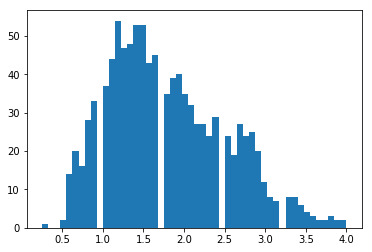

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


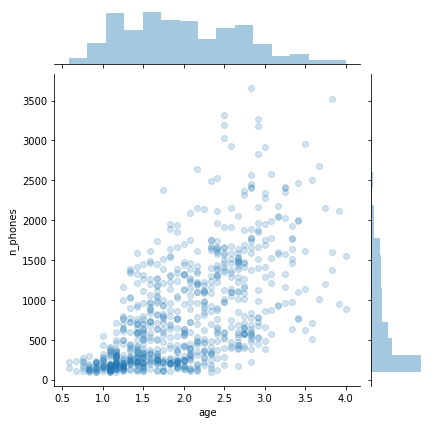

In [10]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [11]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

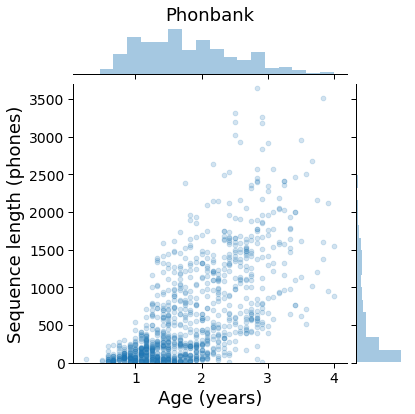

In [12]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age", "n_phones", data=phone_df, alpha=0.2, annot_kws={"size": 16})

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (phones)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("Phonbank")
p.ax_joint.set_ylim([0,3700])
save_fig(FIGURE_DIR/ 'distributions' / 'phonbank_distribution')
plt.show()

In [13]:
p.ax_joint

In [14]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [15]:
from childes_mi.information_theory import mutual_information as mi

In [16]:
distances = np.arange(1,101)

#### Run MI by age cohort

In [17]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [18]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [19]:
### sequence length by cohort

In [20]:
def concat(arr):
    """ingore concatenation of zero length list"""
    if len(arr) ==0:
        return []
    else:
        return np.concatenate(arr)

In [21]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [22]:
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = np.median(cohort_subset.n_phones.values)
    print(age_cohort_low, age_cohort_high, median_n_phones)

0.5 1 69.5
1 1.5 189.0
1.5 2 276.0
2 2.5 879.0
2.5 3 1150.0
3 20 1574.0



In [23]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        'shuffling'
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = int(np.median(cohort_subset.n_phones.values))
    
    ### make list of phones
    cohort_phones_list = [
        [
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list:', [' '.join(i) for i in cohort_phones_list][0][:100])
    
    cohort_phones_list_no_repeats = [
        remove_repeats([
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ])
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (no repeats):', [' '.join(i) for i in cohort_phones_list_no_repeats][0][:100])

    ### make list of phones shuffled within words
    cohort_phones_list_shuffled_within_words = [
            list(concat([np.random.permutation(list(i)) for i in flatten(row.phones) if i is not None]))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled within word):', [' '.join(i) for i in cohort_phones_list_shuffled_within_words][0][:100])

    ### make list of phones shuffled between words
    cohort_phones_list_shuffled_between_words = [
            list(''.join(list(np.random.permutation([i for i in flatten(row.phones) if i is not None]))))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled between word):', [' '.join(i) for i in cohort_phones_list_shuffled_between_words][0][:100])

    cohort_phones_list_shuffled_within_utterance = [list(np.concatenate([np.random.permutation(list(''.join(list(flatten([i for i in sent if i is not None]))))) for sent in  trans]))
     for trans in cohort_subset.phones.values]
    print('phones list (shuffled within utterances):', [' '.join(i) for i in cohort_phones_list_shuffled_within_utterance][0][:100])

    # get number of unique elements
    n_phones = len(np.concatenate(cohort_phones_list))
    n_unique_phones = 0 #len(np.unique(np.concatenate(cohort_phones)))
    
    
    distances = np.arange(1, np.max([100, median_n_phones]) + 1)
    
    # make each phone symbol specific to the transcript
    for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
        cohort_phones_list[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_within_utterance[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_within_utterance[transcript_i]]
        cohort_phones_list_no_repeats[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_no_repeats[transcript_i]]

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'full'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_between_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_between_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_utterance, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_utterance'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_no_repeats, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'no_repeats'
    ]

phones list: ˈ n a ɪ ʌ ˈ j ɪ ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ 
phones list (no repeats): ˈ n a ɪ ʌ ˈ j ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ m 
phones list (shuffled within word): ɪ n a ˈ j ʌ ɪ ˈ b ɪ ˈ ʌ m ʌ b ˈ ə m ɛ ˈ d ɑ ˈ b ɛ ˈ i ˈ m ɪ b ˈ ˈ ʌ ˈ ɪ a ɛ t ˈ ɡ ɪ ˈ a ɪ ɡ ˈ ʌ d ˈ 
phones list (shuffled between word): ˈ ɑ ː m ˈ k i u ə ˈ m ɑ ˈ h ɛ ˈ ɛ ʔ ˈ ɡ ɪ ˈ d æ ˈ e ɪ ˈ h ɑ u ˈ æ ˈ m ɪ * ə ˈ b u ˈ b ʊ k t ˈ d e ɪ 
phones list (shuffled within utterances): n ˈ ɪ a ˈ ʌ j ɪ m ɪ ʌ b ˈ b ʌ ə ˈ m d ɛ ˈ ˈ ɑ b ɛ ˈ i m ˈ b ˈ ɪ ˈ ʌ a ɪ t ɛ ˈ ɪ ˈ ɡ ɪ ˈ ɡ a d ˈ ʌ m 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.5s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    8.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   10.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.5s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    8.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.1s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    9.2s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.0s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    8.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished


phones list: ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (no repeats): ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (shuffled within word): ʊ a ˈ u ˈ ˈ i ɑ ˈ ɔ ˈ ˈ e ð i ɪ ˈ ð ʊ a ɪ ˈ z j ˈ æ ˈ ɪ ʌ ɔ ˈ ʔ ː ɔ ə ˈ ɔ ʔ ə ˈ ː ˈ o ː ˈ i ˈ ː i i 
phones list (shuffled between word): ˈ ɪ ː o ˈ w ɑ ˈ b ɑ ʔ ˈ k w æ ː ˈ u ˈ b ʌ ˈ ɡ ɪ ˈ b u ˈ b u ː ˈ b ɑ p ˈ d i ː ˈ w ɛ ʔ o ˈ w ʌ ˈ b ʊ 
phones list (shuffled within utterances): ʊ ˈ a ˈ ɔ i ˈ ɑ ˈ ˈ u ˈ i ð e ɪ ʊ ð ˈ a j ɪ z æ ˈ ˈ ˈ ɪ ˈ ɔ ʌ ˈ ə ʔ ː ɔ ə ː ɔ ʔ ˈ o ˈ i ː ˈ ˈ ː i ˈ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   56.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   58.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   45.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   46.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    4.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:    6.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    6.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   57.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   59.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   47.6s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   48.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   57.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   58.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   48.3s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   49.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   55.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   57.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 164 out of 189 | elapsed:   48.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   50.1s finished


phones list: h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (no repeats): h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (shuffled within word): h ɪ ˈ i m u ˈ b ə t s ˈ h ɪ ɪ * ʊ ʌ ˈ h ə u b ˈ * ɪ ː h ˈ e t ʌ ˈ ɑ ˈ i m m ɪ s i ɾ ˈ ə w ˈ æ s ʔ e 
phones list (shuffled between word): ˈ ɛ ə ˈ w a ʊ ˈ t ɑ ˈ ʌ ʔ o ˈ ɑ ˈ ʌ t n j o ˈ ʌ t ˈ a ɪ s ˈ m ɑ m i ˈ s æ ʔ ˈ a ɪ w ə s d i j ɛ ˈ w 
phones list (shuffled within utterances): i m ˈ h ɪ u b ˈ ˈ * ə ɪ t ʌ s ʊ h h ˈ ɪ ˈ b ə u h ɪ e ː * ˈ t ˈ ʌ ɑ ˈ m i m ˈ ɾ s ɪ i ə æ s w ˈ ʔ ʌ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.7min remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.7min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.5min remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.5min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:    9.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    9.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:   10.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   10.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.7min remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.7min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.4min remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.5min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.7min remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.7min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.5min remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.5min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.7min remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.7min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 269 out of 276 | elapsed:  1.4min remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.5min finished


phones list: ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (no repeats): ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (shuffled within word): ˈ z ɛ ɑ k ˈ b o * m ˈ m ɑ i w ɪ e ˈ m ɪ ː ˈ ɛ ɑ ˈ m m i ɛ ˈ ˈ m ɑ i m ˈ ɛ i m ɑ m ˈ ɛ ˈ m i m ɑ ˈ m 
phones list (shuffled between word): ˈ ɪ m ɑ m i ˈ ɑ ː ˈ d ɛ ˈ d i ˈ b j u ˈ w a ɪ ˈ ɡ o ˈ m i ð i ˈ h ɑ t t w ə ˈ ɡ i ˈ k ɑ w u ˈ m ɛ ˈ 
phones list (shuffled within utterances): ˈ b z ˈ ɑ k ɛ o w i ˈ m m ɑ ɪ * e ɪ m ˈ ˈ m ɛ ɑ i m ː ˈ ɑ m ˈ ɛ ˈ i m m ˈ ɛ ɛ ˈ i ˈ m i m ɑ m ˈ ɑ m 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  5.4min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  4.7min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   21.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:   34.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  5.5min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  4.7min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  5.3min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  4.8min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  5.3min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 879 out of 879 | elapsed:  4.7min finished


phones list: ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (no repeats): ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (shuffled within word): i h ˈ ˈ h æ r s ə ˈ h i h æ ˈ r s ə k ə ʔ v ˈ æ l s i p ˈ ˈ s p ʊ o ˈ n ɪ ˈ w f a ʌ n ˈ ʌ n ˈ o n ˈ 
phones list (shuffled between word): ˈ ɡ o ˈ s e ɪ ˈ θ e ɪ ɡ ˈ d ɪ s ˈ d ɪ s ˈ m ɔ ɪ ə ˈ m a ɪ ˈ v a ɪ n ˈ e ɪ t ə ˈ ɡ o ˈ ɛ n ˈ ɡ ɛ ˈ t 
phones list (shuffled within utterances): r h s ˈ h ə æ i ˈ r ə h ˈ i s h ˈ æ p s ə æ ˈ k ʔ v l i ˈ ʊ ˈ p s ˈ n o ɪ a f w ˈ n n o n ʌ ˈ ˈ ˈ ʌ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  7.0min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  6.1min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   28.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   44.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  7.1min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  6.3min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  7.0min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  6.2min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:  6.1min finished


phones list: ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (no repeats): ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (shuffled within word): j s ɛ ˈ ˈ l p z i ˈ l ʊ k ɪ ˈ a h ʒ ˈ ʒ i ˈ d d i w ʌ ˈ i ˈ d o w ɛ z ˈ s l z t ə ɛ ˈ n ɪ ɡ ˈ * s ˈ 
phones list (shuffled between word): ˈ ɛ n ˈ h æ ː v d ɪ s ˈ l o p ə n ˈ ʃ i p ˈ p l i z ˈ m ɑ m i ˈ h ɑ t i ˈ r i ŋ i ŋ ˈ f ɔ ˈ l a ɪ k 
phones list (shuffled within utterances): ˈ s ɛ j p i z l ˈ l ˈ ʊ k d i ˈ a d ˈ h ˈ ʒ ʒ i ɪ ˈ i d w o ˈ ʌ ˈ ˈ ɡ t z z ˈ w ɛ n l ɛ ɪ ə s ː i ˈ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:  5.5min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  2.1min
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:  5.5min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1574 out of 1574 | elapsed:  4.9min finished


In [24]:
mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_with_shuffling_median.pickle")

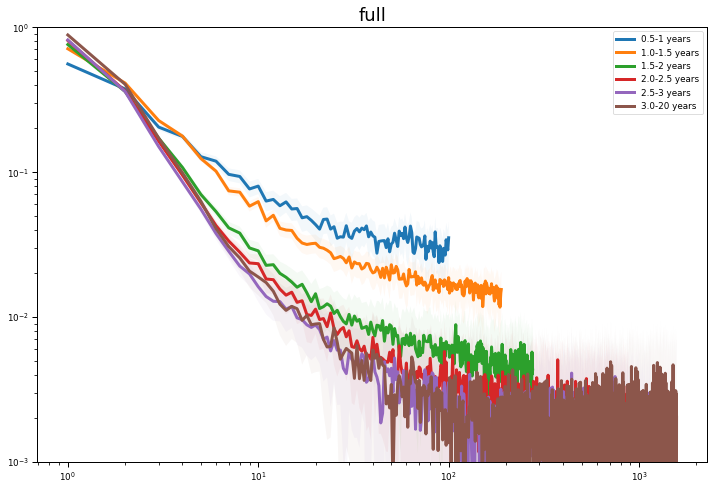

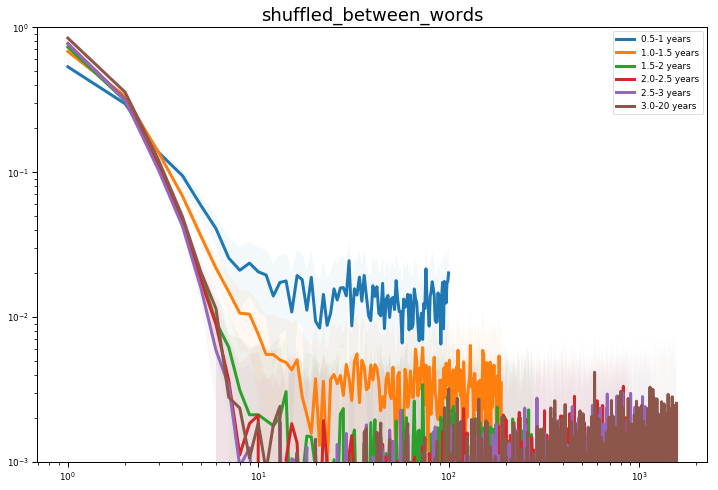

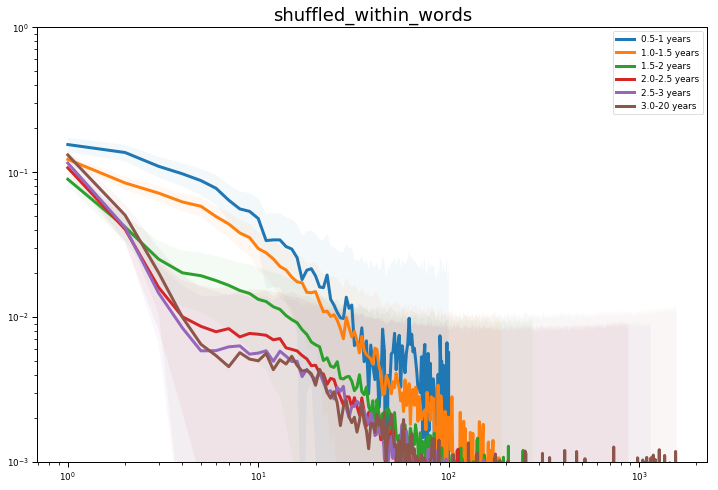

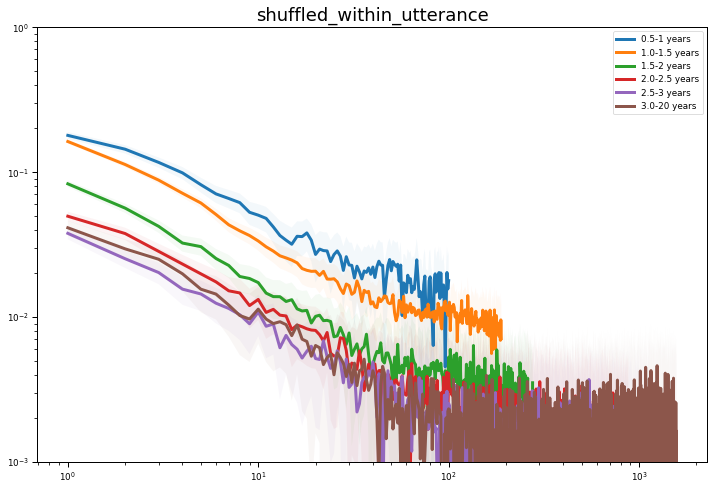

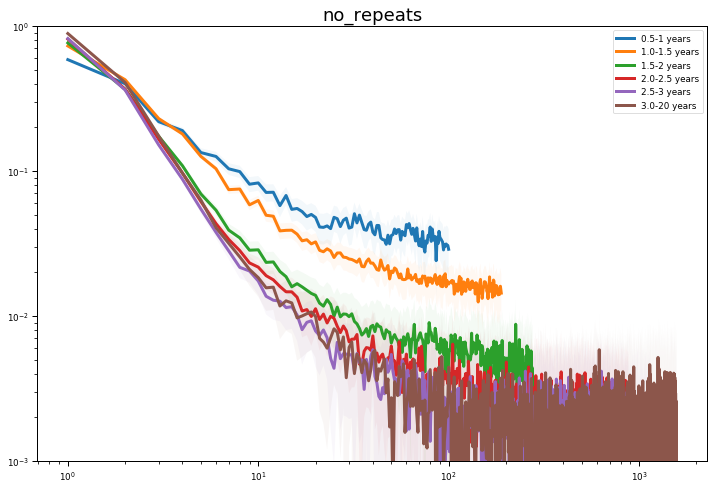

In [25]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'no_repeats']:
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title(shuff)
    for idx, row in mi_df.iterrows():
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax.plot(row.distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.05)

    ax.legend()
    ax.set_ylim([1e-3,1])
    #ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()

full


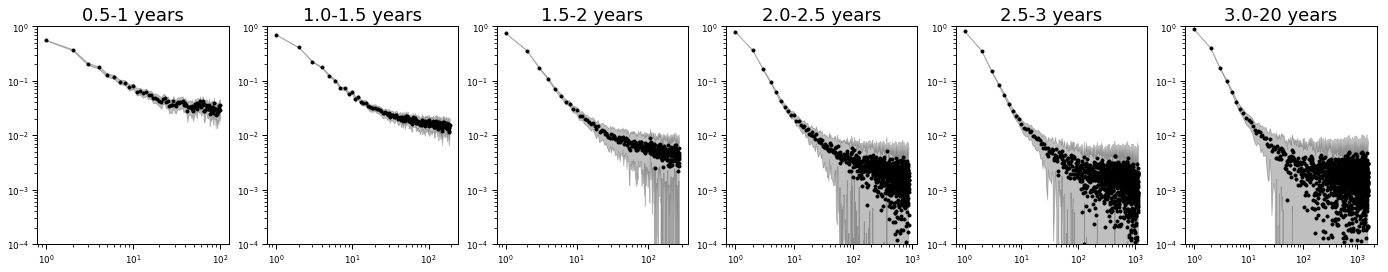

shuffled_between_words


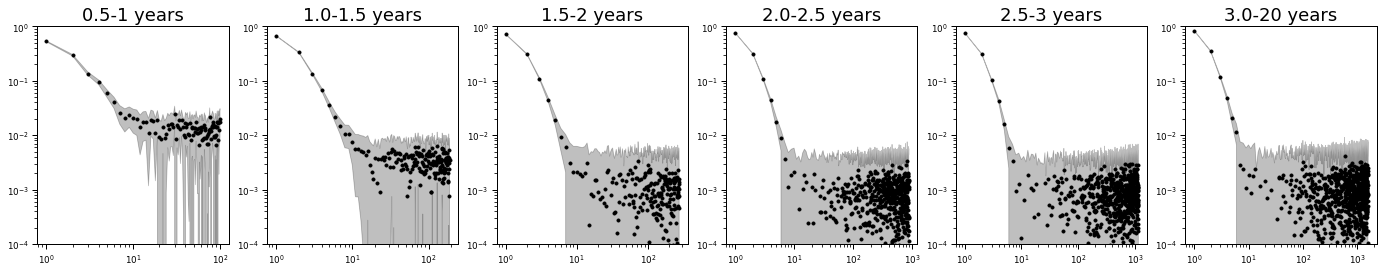

shuffled_within_words


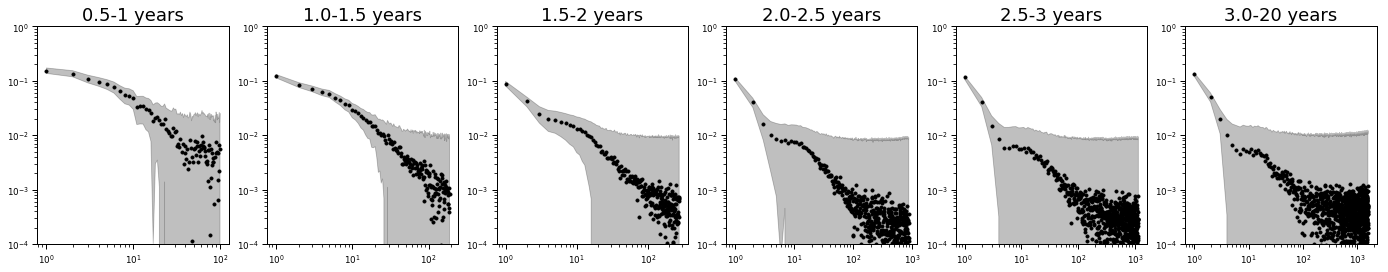

shuffled_within_utterance


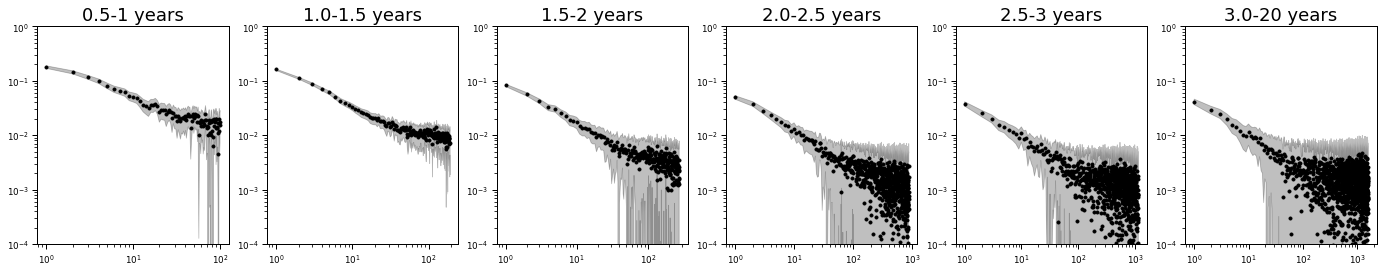

no_repeats


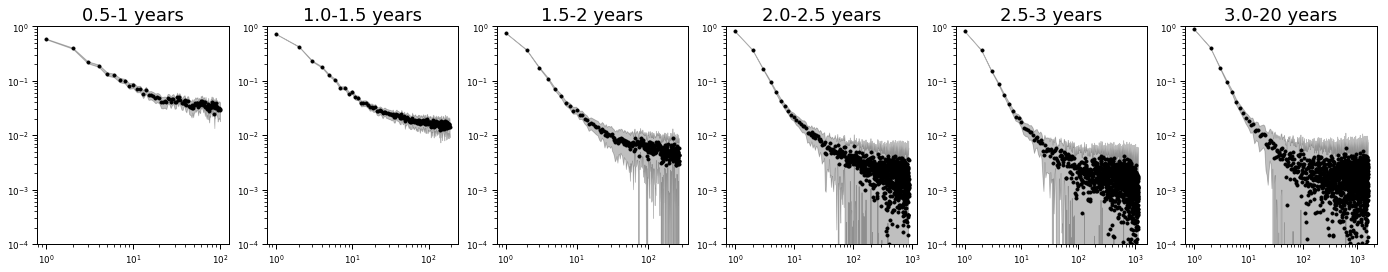

In [28]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'no_repeats']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(row.distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()

full


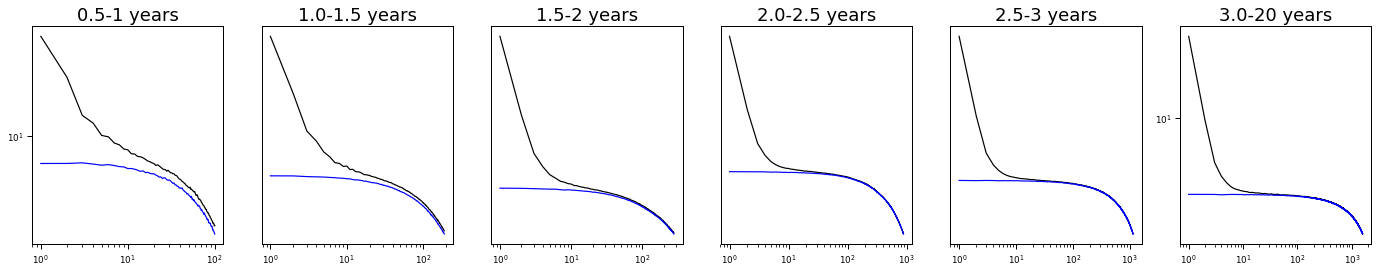

shuffled_between_words


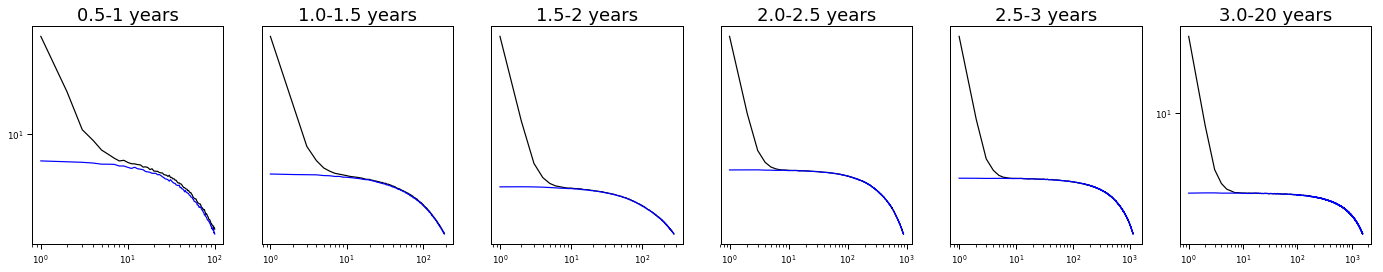

shuffled_within_words


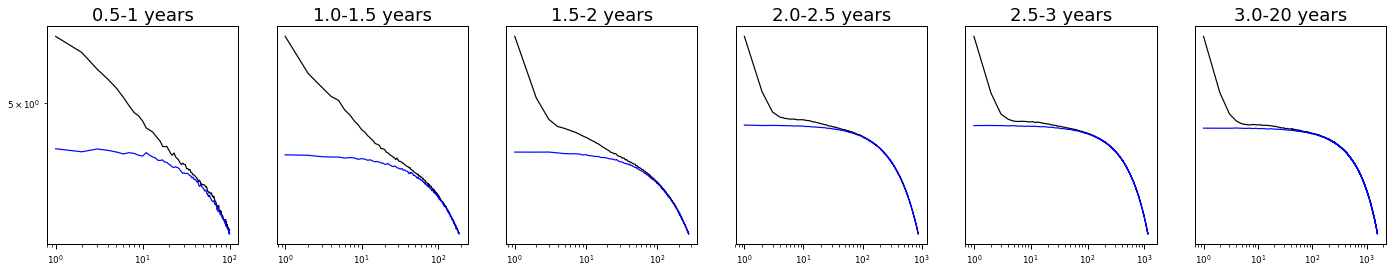

shuffled_within_utterance


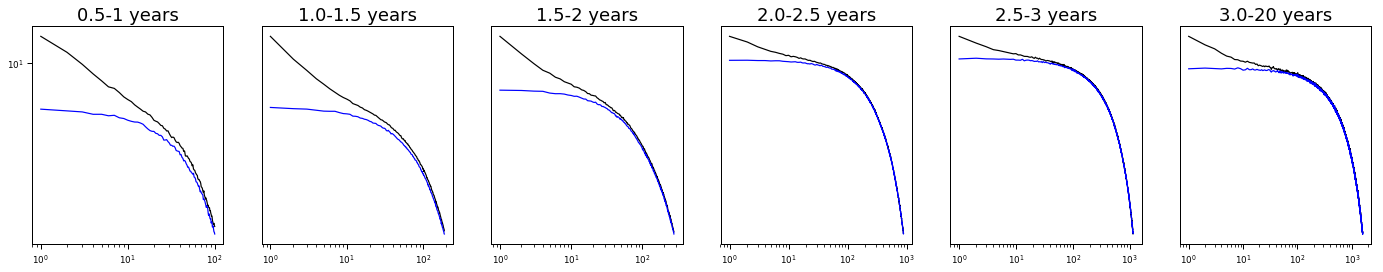

no_repeats


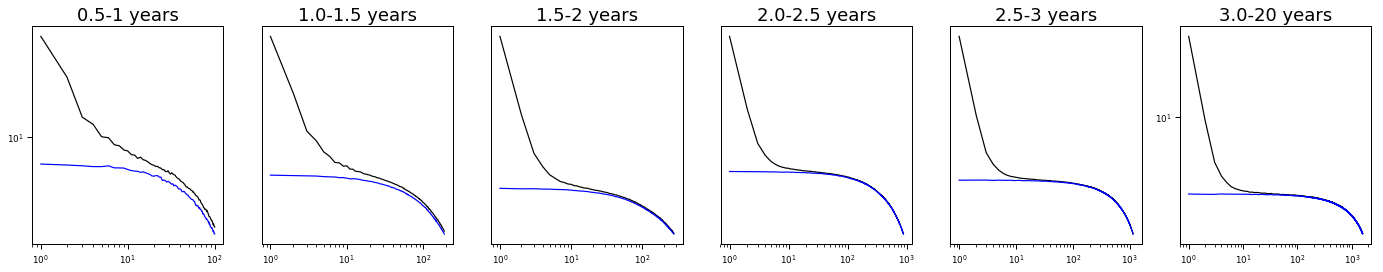

In [27]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'no_repeats']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.plot(row.distances, row.MI, color='k')
        ax.plot(row.distances, row.shuff_MI, color='b')
        #ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        #ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()